In [2]:
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import pandas as pd
import numpy as np

In [3]:
# Import Data
path = '/Users/las/Documents/Forschung/REU/Code/HillClimbML/hill_climb_w_solution_counts.xlsx'
df = pd.read_excel(path)

batch_1 = df[[col for col in df.columns if col[0].isupper()]].rename(str.lower, axis='columns')
batch_2 = df[[col for col in df.columns if col[0].islower()]].rename(str.lower, axis='columns')
batch_2.insert(0, "counts", np.array(batch_1['counts']) - 2)
batch_2[batch_2['counts'] < 0] = 0
data = batch_1.append(batch_2).reset_index().drop('index', axis=1)
data.sample()

,a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,b5,b6,c1,c2,c3,c4,c5,c6,counts
189072,0.952643,0.607411,0.348399,0.761783,0.774171,0.215511,0.789947,0.8051,0.187243,0.399251,0.104148,0.546969,0.569703,0.885278,0.706541,0.770238,0.667778,0.41768,10


In [7]:
# Create Training and Validation Data
# mit categorical cross entropy: count = [[1 if val == i else 0 for i in range(0, 184, 2)] for val in data['counts'].values.tolist()]
count = data['counts'].values.tolist()
param = data.drop('counts', axis=1).values.tolist()
n = int(0.95*len(count))

count_train, count_val = count[:n], count[n:]
param_train, param_val = param[:n], param[n:]

In [8]:
# Set Up Network Architecture
model = keras.Sequential([
    keras.layers.Dense(units=32, activation='relu', input_shape=(18,)),
    keras.layers.Dense(units=64, activation='relu'),    
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=128, activation='relu'),    
    keras.layers.Dense(units=96, activation='relu'),
    keras.layers.Dense(units=92, activation='softmax')
])

2022-07-26 01:41:30.196221: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-26 01:41:30.199724: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


In [9]:
import keras.backend as K

# def delta_n(y_true, y_pred):
#     #TODO, accuracy als metriv verwerfen
#     return K.abs(y_pred-y_true) # BIST DU DUMM daS siNd 18 dim Vektoren.... 

cce = keras.losses.CategoricalCrossentropy()
sce = keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer='RMSprop', 
              loss=sce,
              metrics=[sce, 'accuracy'])

model.summary()

Using TensorFlow backend.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                608       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 96)                12384     
_________________________________________________________________
dense_5 (Dense)              (None, 92)                8924      
Total params: 48,860
Trainable params: 48,860
Non-trainable params: 0
____________________________________________________

In [10]:
# Train model
history = model.fit(param_train,
                    count_train,
                    verbose=2,
                    epochs=25,
                    batch_size=64,
                    validation_data=(
                        param_val,
                        count_val
                    )
)

Train on 190000 samples, validate on 10000 samples
Epoch 1/25
190000/190000 - 45s - loss: 2.5381 - sparse_categorical_crossentropy: 2.5381 - accuracy: 0.1890 - val_loss: 2.3614 - val_sparse_categorical_crossentropy: 2.3624 - val_accuracy: 0.2616
Epoch 2/25
190000/190000 - 36s - loss: 2.4617 - sparse_categorical_crossentropy: 2.4617 - accuracy: 0.2030 - val_loss: 2.3504 - val_sparse_categorical_crossentropy: 2.3515 - val_accuracy: 0.2677
Epoch 3/25
190000/190000 - 34s - loss: 2.4308 - sparse_categorical_crossentropy: 2.4308 - accuracy: 0.2108 - val_loss: 2.3347 - val_sparse_categorical_crossentropy: 2.3349 - val_accuracy: 0.2708
Epoch 4/25
190000/190000 - 34s - loss: 2.4102 - sparse_categorical_crossentropy: 2.4103 - accuracy: 0.2171 - val_loss: 2.3712 - val_sparse_categorical_crossentropy: 2.3718 - val_accuracy: 0.2609
Epoch 5/25
190000/190000 - 43s - loss: 2.3979 - sparse_categorical_crossentropy: 2.3979 - accuracy: 0.2192 - val_loss: 2.3141 - val_sparse_categorical_crossentropy: 2.31

[]

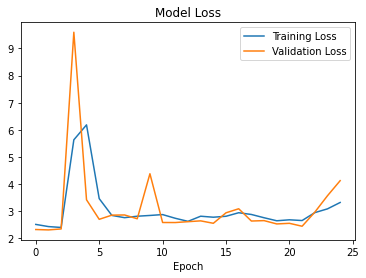

In [ ]:
# Graphs
fig = plt.figure()
plt.title('Model Loss')
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.plot()

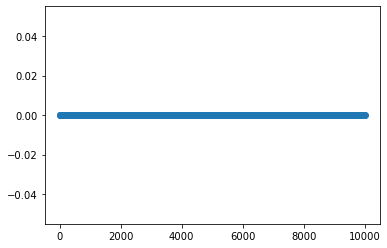

In [ ]:
# Inspect Predictions / reverse one-hot-encoding
def rev(array):
    #TODO noch vektorisieren
    for i, val in enumerate(array):
        if val == 1:
            return 2*i

fig = plt.figure()
prediction = model.predict(param_val)
prediction = [rev(pred) for pred in prediction]
plt.plot(prediction, 'o')
plt.show()